# LSTM, GRUs and CNNs

TODO:

- [ ] WaveNet model not working well, need to check it

# Initialize

## Packages

### General

In [55]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from importlib import reload

Save data to Google Drive

In [56]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    print("Running in Google Colab")
    in_colab=True
except:
    print("Running locally")
    in_colab=False

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Running in Google Colab


Formatting

In [57]:
# For ASCII plots of training progress
try:
    import asciichartpy
except ImportError:
    !pip install asciichartpy
    import asciichartpy

from IPython.display import clear_output

### ML

In [58]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy

Enables GPU support

In [59]:
if not torch.cuda.is_available():
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")
else:
    # Iterate through all available GPU devices and print their names.
    for idx in range(torch.cuda.device_count()):
        print(f"Device Name: {torch.cuda.get_device_name(idx)}")

Device Name: Tesla T4


In [60]:
import pandas as pd

## Helper functions

Here we define a couple of helper functions that we will reuse several times. Most of magic happens inside `my_functions.py`.

In [61]:
if in_colab:
  sys.path.append('/content/drive/MyDrive/Colab Notebooks/pytorch')

import my_functions as mine

## Data

### Get data

In [62]:
!wget https://github.com/ageron/data/raw/main/ridership.tgz
!mkdir data
!mv ridership.tgz data
!tar -xvzf data/ridership.tgz --directory=data/

--2025-04-10 22:24:35--  https://github.com/ageron/data/raw/main/ridership.tgz
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ageron/data/main/ridership.tgz [following]
--2025-04-10 22:24:35--  https://raw.githubusercontent.com/ageron/data/main/ridership.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108512 (106K) [application/octet-stream]
Saving to: ‘ridership.tgz’

ridership.tgz       100%[===================>] 105.97K  --.-KB/s    in 0.002s  

2025-04-10 22:24:36 (52.9 MB/s) - ‘ridership.tgz’ saved [108512/108512]

mkdir: cannot create directory ‘data’: File exists
ridership/
rider

In [63]:
# read data
path = Path("data/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])

# some cleaning
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

### Prepares data

Our goal will be to forecast tomorrow’s ridership based
on the ridership of the past 8 weeks of data (56 days). The inputs to our model
will therefore be sequences (usually a single sequence per day once the model is in
production), each containing 56 values from time steps $t – 55$ to $t$. For each input
sequence, the model will output 14 values in a sequence to vector fashion: the forecasts for time step $t + 14$.

Before we continue looking at the data, let's **split the time series into three periods, for training, validation and testing**. We won't look at the test data for now:

In [64]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

Defines the dataframe and features. Now `df_mulvar` is a DataFrame with five columns: the bus and rail data, plus three
columns containing the one-hot encoding of the next day’s type (recall that there are
three possible day types, W, A, and U).

In [65]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar, dtype=int)  # one-hot encode the day type

In [66]:
df_mulvar.head()

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0


Next we can proceed much like we did earlier.
First we split the data into three periods, for training, validation, and testing:

In [67]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

Training and validation data

In [68]:
ahead = 14       # forecast horizon
seq_length=56

In [69]:
class TSDataset(Dataset):
    def __init__(self, series, history, ahead=14, target_col=1):
        """
        Args:
            series (np.ndarray): the full time series data with shape (num_timesteps, num_features).
            history (int): the number of time steps to use as input (i.e. seq_length).
            ahead (int): the forecast horizon (number of steps ahead).
            target_col (int): the index of the target column (e.g. 1).

        The dataset windows are of length 'history + ahead'. For each window, the first
        'history' time steps become the input features and the following 'ahead' steps (from
        the target column) become the target.
        """
        self.series = series
        self.window_length = history + ahead
        self.history = history
        self.ahead = ahead
        self.target_col = target_col

    def __len__(self):
        # For a series with N timesteps, the number of windows is N - (window_length - 1)
        return len(self.series) - self.window_length + 1

    def __getitem__(self, idx):
        # Extract a window from the series
        window = self.series[idx: idx + self.window_length]
        # Convert to a torch tensor (float32)
        window = torch.tensor(window, dtype=torch.float32)

        # Split the window into:
        # - X: first 'history' steps with all features
        # - y: last 'ahead' steps for the target column
        X = window[:self.history, :]
        y = window[self.history:, self.target_col]
        return X, y

In [70]:
train_series = mulvar_train.to_numpy()
valid_series = mulvar_valid.to_numpy()

# Create dataset objects
train_dataset = TSDataset(train_series, history=seq_length, ahead=ahead, target_col=1)
valid_dataset = TSDataset(valid_series, history=seq_length, ahead=ahead, target_col=1)

# Create data loaders equivalent to the tf.keras dataset pipelines (with batch size of 32)
ahead_train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
ahead_valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# LSTMs

Below: defines model, trains, saves (or loads) model to disk.

In [71]:
class LSTMModel(nn.Module):
    def __init__(self, input_features, hidden_units, num_ahead):
        """
        Args:
            input_features (int): Number of features in the input time series (5 in your case).
            hidden_units (int): Number of units in the LSTM layer (32 in your case).
            num_ahead (int): The forecast horizon (14 in your case).
        """
        super().__init__()
        self.input_features = input_features
        self.hidden_units = hidden_units
        self.num_ahead = num_ahead

        self.lstm = nn.LSTM(input_size=self.input_features,
                            hidden_size=self.hidden_units,
                            batch_first=True)

        self.linear = nn.Linear(in_features=self.hidden_units,
                                out_features=self.num_ahead)

    def forward(self, x):
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, seq_length, input_features).

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, num_ahead).
        """
        lstm_out, _ = self.lstm(x)
        last_time_step_output = lstm_out[:, -1, :]
        predictions = self.linear(last_time_step_output)

        return predictions

In [72]:
# initialize model
lstm_model = LSTMModel(input_features=5, hidden_units=32, num_ahead=ahead)

In [73]:
%time mine.train_save(lstm_model, ahead_train_loader, ahead_valid_loader, mine.fit_and_evaluate_mulvar, in_colab=in_colab, filename="lstm.pth", learning_rate=0.1, rewrite=False, epochs=1000)

Loading weights from disk: /content/drive/MyDrive/Colab Notebooks/pytorch/models/lstm.pth
Model loaded successfully.
CPU times: user 14 ms, sys: 94 µs, total: 14.1 ms
Wall time: 1.79 s


In [74]:
y_ahead=mine.forecast_ahead(seq_length, mulvar_valid[:seq_length], lstm_model)

# convert to pandas TS
y_aheadP = pd.Series(y_ahead[0, :], index=pd.date_range("2019-02-26", "2019-03-11"))

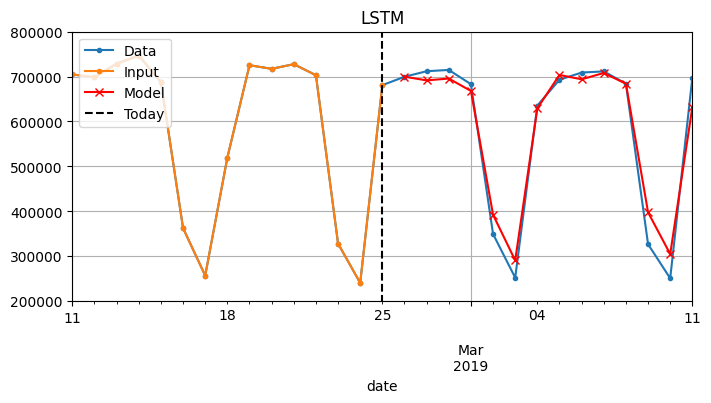

In [75]:
fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(label="Data", marker=".", ax=ax)
(mulvar_valid[0:seq_length]['rail']*1e6).plot(label="Input", marker=".", ax=ax)
(y_aheadP * 1e6).plot(label="Model", grid=True, marker="x", color="r", ax=ax)

ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_xlim(["2019-02-11", "2019-03-11"])
ax.set_ylim([200_000, 800_000])
plt.legend(loc="upper left")
plt.title('LSTM')
plt.show()

# GRUs

In [76]:
class GRUModel(nn.Module):
    def __init__(self, input_features, hidden_units, num_ahead):
        super().__init__()
        self.input_features = input_features
        self.hidden_units = hidden_units
        self.num_ahead = num_ahead

        self.gru = nn.GRU(input_size=self.input_features,
                            hidden_size=self.hidden_units,
                            batch_first=True)

        self.linear = nn.Linear(in_features=self.hidden_units,
                                out_features=self.num_ahead)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        last_time_step_output = gru_out[:, -1, :]
        predictions = self.linear(last_time_step_output)

        return predictions

In [77]:
# initialize model
gru_model = GRUModel(input_features=5, hidden_units=32, num_ahead=ahead)

In [78]:
%time mine.train_save(gru_model, ahead_train_loader, ahead_valid_loader, mine.fit_and_evaluate_mulvar, in_colab=in_colab, filename="gru.pth", learning_rate=0.1, rewrite=False, epochs=1000)

Epoch 452/1000, Validation MAE: 0.037274
   -0.73  ┤
   -0.80  ┤
   -0.86  ┤
   -0.93  ┤
   -0.99  ┤
   -1.06  ┤
   -1.13  ┤
   -1.19  ┤
   -1.26  ┤                                           ╭╮               ╭╮
   -1.32  ┤ ╭╮             ╭╮   ╭╮  ╭─╮   ╭─╮         ││         ╭─╮   ││ ╭╮            ╭╮   ╭─╮ ╭╮╭╮╭╮    ╭╮
   -1.39  ┼─╯╰─────────────╯╰───╯╰──╯ ╰───╯ ╰─────────╯╰─────────╯ ╰───╯╰─╯╰────────────╯╰───╯ ╰─╯╰╯╰╯╰────╯╰─
   -1.46  ┤
Early stopping triggered at epoch 452
Saving trained weights to disk: /content/drive/MyDrive/Colab Notebooks/pytorch/models/gru.pth
CPU times: user 5min 17s, sys: 923 ms, total: 5min 18s
Wall time: 5min 20s


34981.68462296811

In [79]:
y_ahead=mine.forecast_ahead(seq_length, mulvar_valid[:seq_length], gru_model)

# convert to pandas TS
y_aheadP = pd.Series(y_ahead[0, :], index=pd.date_range("2019-02-26", "2019-03-11"))

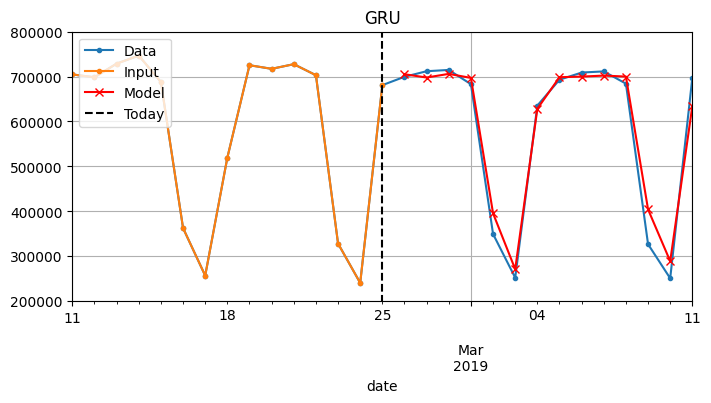

In [80]:
fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(label="Data", marker=".", ax=ax)
(mulvar_valid[0:seq_length]['rail']*1e6).plot(label="Input", marker=".", ax=ax)
(y_aheadP * 1e6).plot(label="Model", grid=True, marker="x", color="r", ax=ax)

ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_xlim(["2019-02-11", "2019-03-11"])
ax.set_ylim([200_000, 800_000])
plt.legend(loc="upper left")
plt.title('GRU')
plt.show()

# 1D CNNs

## Primer

**What Are 1D CNNs?**

Just as 2D CNNs slide small filters across images to detect features, 1D CNNs slide filters across sequences (like time series data). Each filter learns to detect short patterns within the sequence, and using multiple filters creates multiple feature sequences.

For example, with 10 filters, your output becomes either:
- 10 separate sequences (one per filter)
- Or a single sequence where each position has 10 dimensions

**Using 1D CNNs with Sequences**

You can combine 1D convolutional layers with recurrent layers (like GRU or LSTM) in your neural networks. The sequence length after a convolutional layer depends on:

- With stride=1 and "same" padding: Output length equals input length
- With "valid" padding or stride>1: Output length is shorter than input

```
  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

**Practical Example**

Here's a simplified model that uses a 1D CNN to downsample a sequence before processing it with a GRU layer:

```python
model = tf.keras.Sequential([
    # Reduces sequence length by half (stride=2)
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2, activation="relu"),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])
```

When using this downsampling approach:
1. You can process longer input sequences (112 days instead of 56)
2. The CNN helps filter out unimportant details while preserving key information
3. The GRU can more easily detect longer patterns in the shorter sequence
4. You need to adjust your target sequences accordingly (cropping and downsampling)

This combined approach often performs better than using recurrent layers alone. In fact, sometimes you can build effective sequence models using only 1D convolutions without any recurrent layers!

## Model

In [81]:
class CNNGRUModel(nn.Module):
    def __init__(self, input_features, conv_filters, kernel_size, conv_stride,
                 gru_hidden_units, ahead):
        """
        Args:
            input_features (int): Number of features in the input time series (5).
            conv_filters (int): Number of output filters for the Conv1D layer (32).
            kernel_size (int): Kernel size for the Conv1D layer (4).
            conv_stride (int): Stride for the Conv1D layer (2).
            gru_hidden_units (int): Number of units in the GRU layer (32).
            ahead (int): The forecast horizon (14).
        """
        super().__init__()
        self.input_features = input_features
        self.conv_filters = conv_filters
        self.kernel_size = kernel_size
        self.conv_stride = conv_stride
        self.gru_hidden_units = gru_hidden_units
        self.ahead = ahead

        # Define the 1D Convolutional layer
        self.conv1d = nn.Conv1d(in_channels=self.input_features,
                                out_channels=self.conv_filters,
                                kernel_size=self.kernel_size,
                                stride=self.conv_stride)

        # Define the GRU layer
        self.gru = nn.GRU(input_size=self.conv_filters,
                          hidden_size=self.gru_hidden_units,
                          batch_first=True)

        self.linear = nn.Linear(in_features=self.gru_hidden_units,
                                out_features=self.ahead)

    def forward(self, x):
        # --- Conv1D Layer ---
        # Permute for Conv1d: (batch, features, seq_length)
        x_conv = x.permute(0, 2, 1) # Shape: (32, 5, 50)

        # Apply Conv1d
        conv_out = self.conv1d(x_conv) # Shape: (batch, conv_filters, new_seq_length)
                                       # e.g., (32, 32, 24) for seq=50, kernel=4, stride=2

        # Apply ReLU activation (equivalent to activation='relu' in Keras Conv1D)
        relu_out = F.relu(conv_out) # Shape: (32, 32, 24)

        # --- GRU Layer ---
        # Permute for GRU: (batch, new_seq_length, conv_filters)
        gru_input = relu_out.permute(0, 2, 1) # Shape: (32, 24, 32)

        # Apply GRU
        # gru_out shape: (batch, new_seq_length, gru_hidden_units) e.g., (32, 24, 32)
        gru_out, _ = self.gru(gru_input)

        # --- Dense Layer ---
        # Select the output from the last time step of the GRU sequence
        # last_time_step_output shape: (batch_size, gru_hidden_units) e.g., (32, 32)
        last_time_step_output = gru_out[:, -1, :]

        # Apply final Linear layer
        # predictions shape: (batch_size, num_ahead) e.g., (32, 14)
        predictions = self.linear(last_time_step_output)

        return predictions

In [82]:
# initialize model
cnn_model = CNNGRUModel(5, 32, 4, 2, 32, ahead)

## Data with longer sequences

In [83]:
# Create dataset objects
cnn_train_dataset = TSDataset(train_series, history=112, ahead=ahead, target_col=1)
cnn_valid_dataset = TSDataset(valid_series, history=112, ahead=ahead, target_col=1)

# Create data loaders equivalent to the tf.keras dataset pipelines (with batch size of 32)
cnn_train_loader = DataLoader(cnn_train_dataset, batch_size=32, shuffle=True)
cnn_valid_loader = DataLoader(cnn_valid_dataset, batch_size=32, shuffle=False)

## Training

In [84]:
%time mine.train_save(cnn_model, cnn_train_loader, cnn_valid_loader, mine.fit_and_evaluate_mulvar, in_colab=in_colab, filename="cnn.pth", learning_rate=0.1, rewrite=False, epochs=1000)

Loading weights from disk: /content/drive/MyDrive/Colab Notebooks/pytorch/models/cnn.pth
Model loaded successfully.
CPU times: user 3.42 ms, sys: 978 µs, total: 4.4 ms
Wall time: 7.27 ms


In [85]:
y_cnn=mine.forecast_ahead(seq_length, mulvar_valid[:112], cnn_model)

# convert to pandas TS
y_cnnP = pd.Series(y_cnn[0, :], index=pd.date_range("2019-02-26", "2019-03-11"))

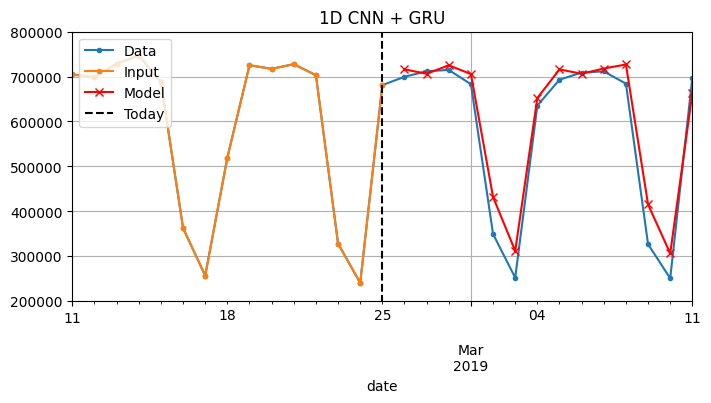

In [86]:
fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(label="Data", marker=".", ax=ax)
(mulvar_valid[0:seq_length]['rail']*1e6).plot(label="Input", marker=".", ax=ax)
(y_cnnP * 1e6).plot(label="Model", grid=True, marker="x", color="r", ax=ax)

ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_xlim(["2019-02-11", "2019-03-11"])
ax.set_ylim([200_000, 800_000])
plt.legend(loc="upper left")
plt.title('1D CNN + GRU')
plt.show()

# WaveNet

WaveNet: Efficient Sequence Processing with Dilated Convolutions

**What is WaveNet?**

WaveNet is an innovative architecture introduced by DeepMind researchers in 2016. It uses a clever arrangement of 1D convolutional layers to efficiently process sequences like audio.

**How Dilated Convolutions Work**

The key innovation in WaveNet is **dilated convolutions** - where filters skip inputs at regular intervals:

- The first layer has a dilation rate of 1 (processes adjacent inputs)
- Each subsequent layer doubles the dilation: 2, 4, 8, 16, 32...

This means:
- Early layers capture short-term patterns (like individual sounds)
- Middle layers capture medium-term patterns
- Deep layers capture long-term patterns (like words or phrases)

**Architecture Benefits**

This design creates a powerful hierarchy where:

1. Lower layers learn local, fine-grained patterns
2. Higher layers learn broader, long-term patterns
3. The network efficiently processes very long sequences

The original WaveNet had 3 identical stacks of 10 convolutional layers each. Each stack used dilation rates of 1, 2, 4, 8, up to 512. This arrangement effectively works like a massive 1,024-width convolutional layer but requires:
- Far fewer parameters
- Much less computation
- Better learning capability

To maintain consistent sequence length, each layer used left-padding with zeros (equal to that layer's dilation rate).

This architecture proved extremely effective for complex sequence modeling tasks, especially audio generation.

```
 ⋮
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\...
   \  /  \  /  \  /  \  /  \  /  \  /  \     
     /    \      /    \      /    \          
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /...\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 111
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 112
 /14 15 16 17 18 19 20 21 22  23 24 25 26 ... 125
```

Same model in keras:

```python
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))
```

In [87]:
class WaveNetModel(nn.Module):
    def __init__(self, input_features, num_filters, kernel_size, num_ahead):
        """
        Args:
            input_features (int): Number of features in the input time series (5).
            num_filters (int): Number of filters in the dilated Conv1D layers (32).
            kernel_size (int): Kernel size for the dilated Conv1D layers (2).
            num_ahead (int): The forecast horizon (14), used for the final Conv1D layer.
        """
        super().__init__()
        self.input_features = input_features
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.num_ahead = num_ahead
        self.dilation_rates = (1, 2, 4, 8) * 2 # (1, 2, 4, 8, 1, 2, 4, 8)

        # Create a ModuleList to hold the dilated convolutional layers
        self.dilated_convs = nn.ModuleList()
        current_channels = input_features

        for dilation_rate in self.dilation_rates:
            self.dilated_convs.append(
                nn.Conv1d(in_channels=current_channels,
                          out_channels=self.num_filters,
                          kernel_size=self.kernel_size,
                          dilation=dilation_rate)
                # We will handle causal padding manually in the forward pass
            )
            # Input channels for the next conv layer is the output channels of the current one
            current_channels = self.num_filters

        # Final 1x1 Convolution to get the desired output dimension (num_ahead)
        self.final_conv = nn.Conv1d(in_channels=self.num_filters,
                                    out_channels=self.num_ahead,
                                    kernel_size=1)

    def forward(self, x):
        # Permute for Conv1d: (batch, features, seq_length)
        x_permuted = x.permute(0, 2, 1) # Shape: (32, 5, 112)

        # Apply dilated convolutions with causal padding
        skip_connections = [] # Optional: Store outputs for skip connections if building a full WaveNet
        current_input = x_permuted

        for i, conv_layer in enumerate(self.dilated_convs):
            # Calculate causal padding: (kernel_size - 1) * dilation
            dilation_rate = self.dilation_rates[i]
            padding_left = (self.kernel_size - 1) * dilation_rate

            # Apply manual left padding using F.pad
            # Pad format: (pad_left, pad_right) for the last dimension (sequence)
            padded_input = F.pad(current_input, (padding_left, 0)) # Shape: (32, channels, seq_len + pad_left)

            # Apply convolution
            conv_out = conv_layer(padded_input) # Shape: (32, num_filters, seq_len)

            # Apply activation (ReLU) - Keras applies it within the layer
            activated_out = F.relu(conv_out) # Shape: (32, num_filters, seq_len)

            # Update input for the next layer
            current_input = activated_out
            # skip_connections.append(conv_out) # If implementing skip connections

        # Apply final 1x1 convolution
        # Input shape: (32, num_filters, seq_len)
        final_conv_out = self.final_conv(current_input) # Shape: (32, num_ahead, seq_len) e.g., (32, 14, 112)

        # Take the output corresponding to the *last* time step for forecasting
        # Select all batches, all output features (num_ahead), and the last element in the sequence dim
        output = final_conv_out[:, :, -1] # Shape: (32, 14)

        return output

In [88]:
# Instantiate the model
wavenet_model = WaveNetModel(5, 32, 2, ahead)

In [89]:
%time mine.train_save(wavenet_model, cnn_train_loader, cnn_valid_loader, mine.fit_and_evaluate_mulvar, in_colab=in_colab, filename="wavenet.pth", learning_rate=0.1, rewrite=False, epochs=1000)

Loading weights from disk: /content/drive/MyDrive/Colab Notebooks/pytorch/models/wavenet.pth
Model loaded successfully.
CPU times: user 5.94 ms, sys: 2 µs, total: 5.94 ms
Wall time: 12.6 ms


In [90]:
y_wave=mine.forecast_ahead(seq_length, mulvar_valid[:112], wavenet_model)

# convert to pandas TS
y_waveP = pd.Series(y_wave[0, :], index=pd.date_range("2019-02-26", "2019-03-11"))

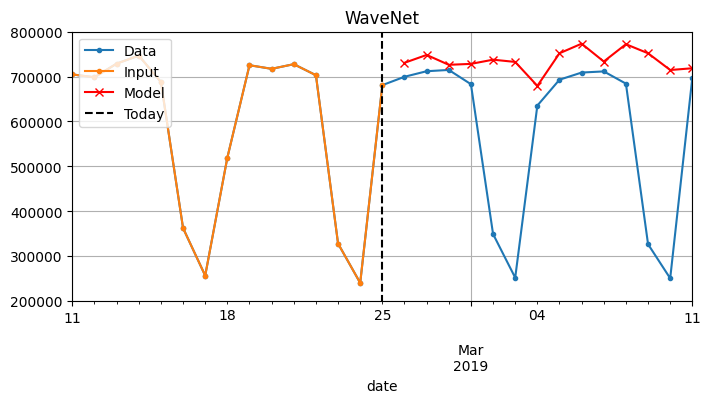

In [91]:
fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(label="Data", marker=".", ax=ax)
(mulvar_valid[0:seq_length]['rail']*1e6).plot(label="Input", marker=".", ax=ax)
(y_waveP * 1e6).plot(label="Model", grid=True, marker="x", color="r", ax=ax)

ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_xlim(["2019-02-11", "2019-03-11"])
ax.set_ylim([200_000, 800_000])
plt.legend(loc="upper left")
plt.title('WaveNet')
plt.show()